[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


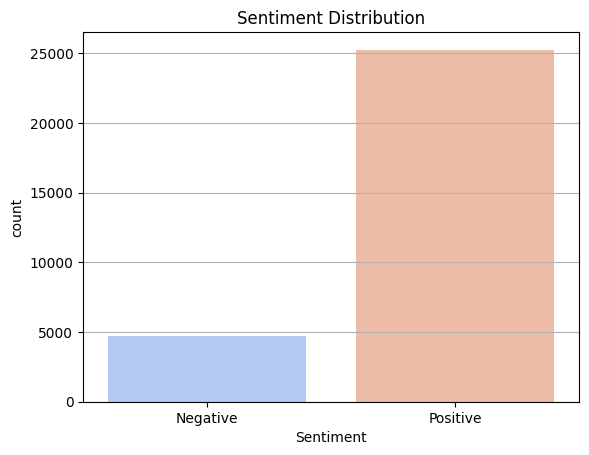


===== Naive Bayes =====
              precision    recall  f1-score   support

    Negative       0.89      0.19      0.31       949
    Positive       0.87      1.00      0.93      5051

    accuracy                           0.87      6000
   macro avg       0.88      0.59      0.62      6000
weighted avg       0.87      0.87      0.83      6000



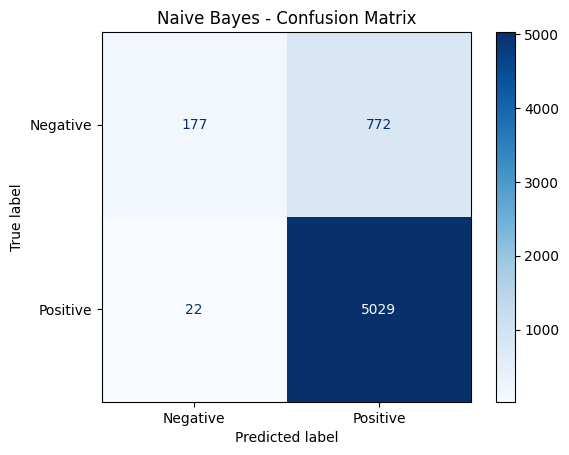


===== Logistic Regression =====
              precision    recall  f1-score   support

    Negative       0.59      0.83      0.69       949
    Positive       0.97      0.89      0.93      5051

    accuracy                           0.88      6000
   macro avg       0.78      0.86      0.81      6000
weighted avg       0.91      0.88      0.89      6000



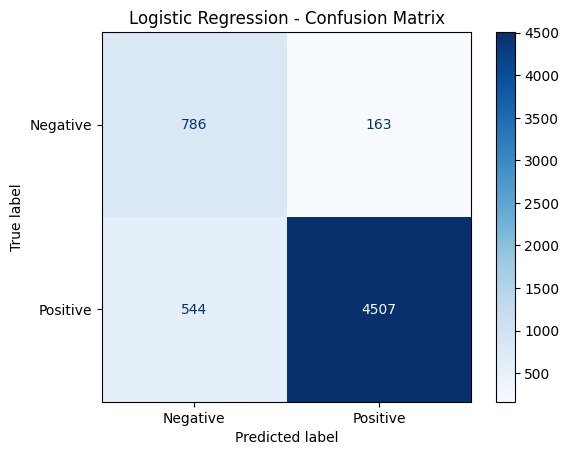


===== SVM =====
              precision    recall  f1-score   support

    Negative       0.78      0.64      0.70       949
    Positive       0.93      0.97      0.95      5051

    accuracy                           0.91      6000
   macro avg       0.86      0.80      0.83      6000
weighted avg       0.91      0.91      0.91      6000



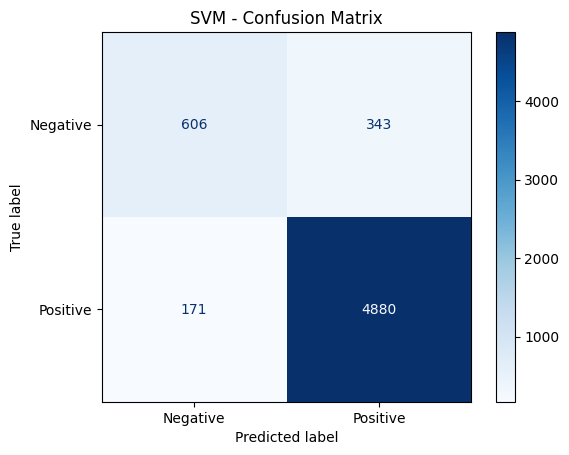

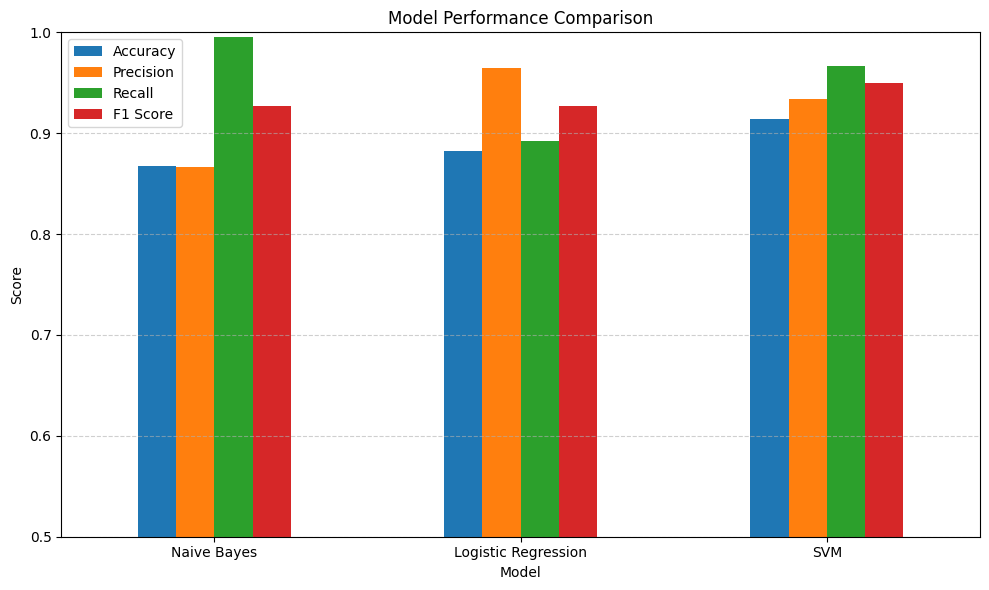

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import warnings
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Setup
warnings.filterwarnings('ignore')
nltk.download('stopwords')

# Load & clean
df = pd.read_csv('Reviews.csv')[['Score', 'Text']].dropna()
df = df[df['Score'] != 3]
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)
df = df.sample(n=30000, random_state=42)

# Preprocessing
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return ' '.join([word for word in text.split() if word not in stop_words])
df['cleaned'] = df['Text'].apply(clean_text)

# EDA Plot: Sentiment Distribution
sns.countplot(data=df, x='Sentiment', palette='coolwarm')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title("Sentiment Distribution")
plt.grid(axis='y')
plt.show()

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned']).toarray()
y = df['Sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM": LinearSVC()
}

# Store results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Print classification report
    print(f"\n===== {name} =====")
    print(classification_report(y_test, preds, target_names=["Negative", "Positive"]))

    # Save metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1 Score': f1_score(y_test, preds)
    })

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.grid(False)
    plt.show()

# Summary Plot: Metric Comparison
results_df = pd.DataFrame(results).set_index('Model')
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [2]:
!pip install tensorflow imbalanced-learn


In [3]:
# === ADDITIONAL SECTION: SMOTE Balancing & LSTM ===

# 1. SMOTE Balancing for Class Imbalance
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Apply SMOTE on training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Retrain model on balanced data
lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(X_resampled, y_resampled)

# Evaluate on original test set
smote_preds = lr_smote.predict(X_test)
print("\n===== Logistic Regression (After SMOTE) =====")
print(classification_report(y_test, smote_preds))

# 2. LSTM Deep Learning Sentiment Classifier (Optional)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned'])
sequences = tokenizer.texts_to_sequences(df['cleaned'])

X_dl = pad_sequences(sequences, maxlen=100)
y_dl = df['Sentiment'].values

# Train-test split for LSTM
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_dl, test_size=0.2, stratify=y_dl, random_state=42)

# Build LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM model
lstm_model.fit(X_train_dl, y_train_dl, epochs=3, batch_size=128, validation_split=0.1)

# Evaluate LSTM model
loss, accuracy = lstm_model.evaluate(X_test_dl, y_test_dl)
print(f"\nLSTM Test Accuracy: {accuracy:.4f}")



===== Logistic Regression (After SMOTE) =====
              precision    recall  f1-score   support

           0       0.62      0.80      0.70       949
           1       0.96      0.91      0.93      5051

    accuracy                           0.89      6000
   macro avg       0.79      0.85      0.82      6000
weighted avg       0.91      0.89      0.90      6000

Epoch 1/3
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.8359 - loss: 0.4620 - val_accuracy: 0.9062 - val_loss: 0.2431
Epoch 2/3
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 169ms/step - accuracy: 0.9314 - loss: 0.1881 - val_accuracy: 0.9021 - val_loss: 0.2406
Epoch 3/3
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - accuracy: 0.9518 - loss: 0.1410 - val_accuracy: 0.9050 - val_loss: 0.2486
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9116 - loss: 0.2614

LSTM Test Accuracy: 0.9137


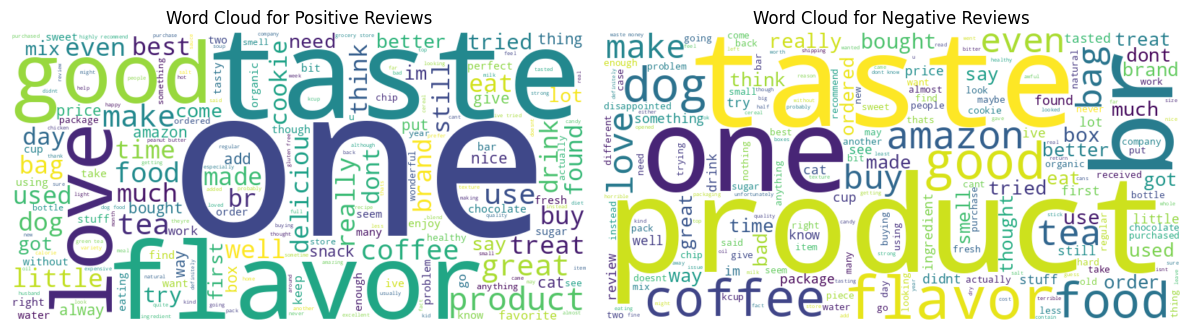

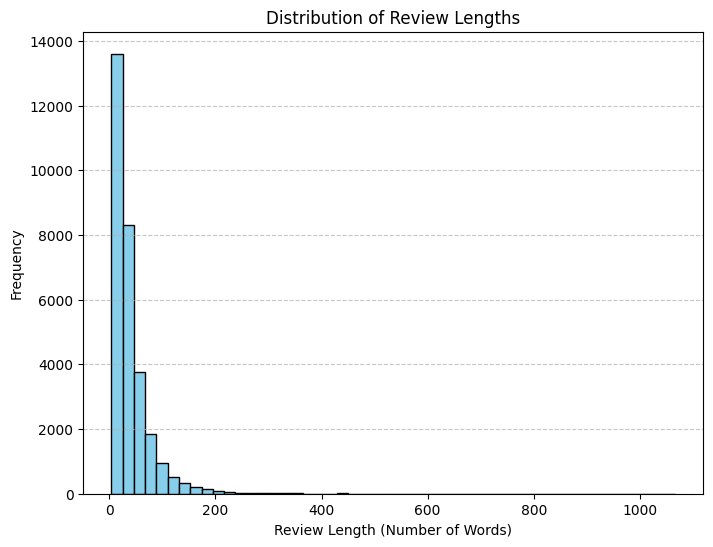

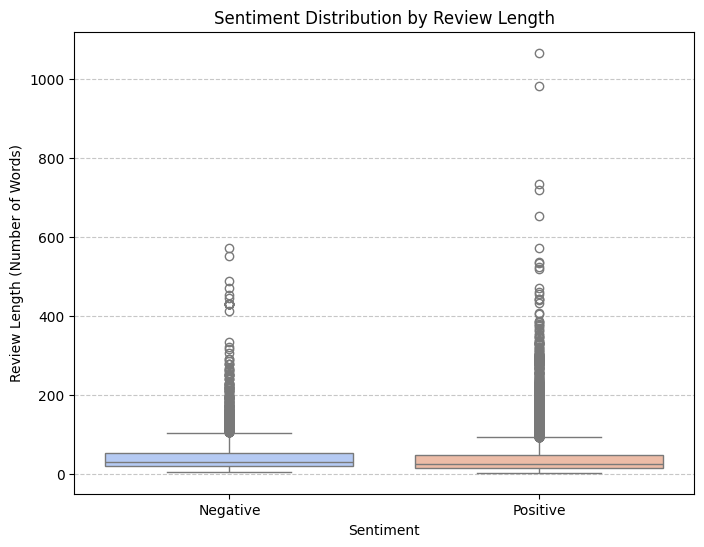

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Word Cloud for Positive and Negative Reviews

# Positive reviews
positive_reviews = ' '.join(df[df['Sentiment'] == 1]['cleaned'])
# Negative reviews
negative_reviews = ' '.join(df[df['Sentiment'] == 0]['cleaned'])

# Generate WordClouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot WordClouds
plt.figure(figsize=(12, 6))

# Positive review word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Positive Reviews")
plt.axis('off')

# Negative review word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Negative Reviews")
plt.axis('off')

plt.tight_layout()
plt.show()

# 2. Review Length Distribution

# Calculate review lengths
df['review_length'] = df['cleaned'].apply(lambda x: len(x.split()))

# Plot distribution of review lengths
plt.figure(figsize=(8, 6))
plt.hist(df['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length (Number of Words)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Sentiment Distribution by Review Length

# Plot sentiment distribution by review length
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentiment', y='review_length', data=df, palette='coolwarm')
plt.title("Sentiment Distribution by Review Length")
plt.xlabel("Sentiment")
plt.ylabel("Review Length (Number of Words)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()
